In [830]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import copy
from collections import defaultdict

from Components.ConditionalNormalDistribution import ConditionalNormalDistribution
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelExponential import ModelExponential
from Models.ModelSinCos import ModelSinCos
from Models.ModelLogistic import ModelLogistic
from Models.ModelSigmoid import ModelSigmoid
from Composition.SequentialSystem import SequentialSystem
from SearchAlgorithm.skeleton import BO_skeleton, BO_graph

from GraphDecomposition.DirectedFunctionalGraph import DirectedFunctionalGraph
from Components.DifferentiablePolynomial import DifferentiablePolynomial
from Models.ModelSinCos import ModelSinCos
from Models.ModelConstant import ModelConstant
from Models.ModelWeightedSum import ModelWeightedSum
from Models.ModelExponential import ModelExponential

%load_ext autoreload
%autoreload 2
from GraphDecomposition.Heuristic import *
from helper import *
from Plotting.HeatMapLossFunction import *



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [831]:
# ground truth param

ground_truth_param = {1 : np.array([0.7, 1.1, -0.5]), 2: np.array([0.4, 0.5]), 8: np.array([-0.2, -0.2]), 9: np.array([-0.5, 0.5]), 10: np.array([-0.2, 0.1]), 11: np.array([-0.3, 0.3, 0.2]),
                      12: np.array([0.1, 0.1]), "Blackbox3":np.array([1.3, -0.5]), 4:np.array([1.1, -0.5]), "Blackbox5":np.array([0.7, -0.5]),
                      "Blackbox6": np.array([0.7, 1.1]), 7: np.array([0.7, -0.5])}

# single input, single output
def get_data(component : Model, input_range_lower, input_range_upper, ground_truth_param, noisy=True):
    # ground truth for training
    component = copy.deepcopy(component)
    component.set_params(ground_truth_param)

    X_local = torch.tensor(np.random.uniform(input_range_lower, input_range_upper, size=100))
    y_local = component.forward(X_local, noisy=noisy)  # labeling effort of A

    return X_local, y_local

# multi input, single output (default is input size 2)
def get_data_tree(component : Model, input_range_lower, input_range_upper, ground_truth_param, inputs=2):
    # ground truth for training
    component = copy.deepcopy(component)
    component.set_params(ground_truth_param)

    X_local = torch.tensor(np.random.uniform(input_range_lower, input_range_upper, size=(inputs,100)))
    y_local = component.forward(X_local, noisy=True)  # labeling effort of A

    return X_local, y_local


In [717]:
# def generate_dg_test():
#     ground_truth_param = {1 : np.array([0.7, -0.5]), 2: np.array([0.2, 0.6]), 3: np.array([-0.5, 0.5, 0.5]), "Blackbox4": np.array([0.5])}
#     np.random.seed = 1
#     DG = DirectedFunctionalGraph()

#     # white box components
#     DG.add_node(1, component=ModelWeightedSum())
#     x,y = get_data_tree(DG.nodes[1]["component"], -5, 5, ground_truth_param[1])
#     DG.nodes[1]["component"].attach_local_data(x,y)

#     DG.add_node(2, component=ModelSinCos())
#     x,y = get_data(DG.nodes[2]["component"], -3, 3, ground_truth_param[2])
#     DG.nodes[2]["component"].attach_local_data(x,y)
    
#     DG.add_node(3, component=DifferentiablePolynomial())
#     x,y = get_data(DG.nodes[3]["component"], -3, 3, ground_truth_param[3])
#     DG.nodes[3]["component"].attach_local_data(x,y)

#     # black box components
#     DG.add_node("Blackbox4", component=ModelSigmoid())
#     DG.nodes["Blackbox4"]["component"].set_params(ground_truth_param["Blackbox4"])

#     # Test warning for multiple parents
#     DG.add_edge([2,3],1)

#     DG.add_edge(3,"Blackbox4")

#     X_end, y_end = get_end_to_end_data(DG, ground_truth_param)
#     DG.system_x = X_end
#     DG.system_y = y_end
    
#     DG.random_initialize_param()
#     return DG


# Generate the system

In [832]:
def generate_dg():
    np.random.seed = 10
    DG = DirectedFunctionalGraph()

    # white box components
    DG.add_node(1, component=DifferentiablePolynomial())
    x,y = get_data(DG.nodes[1]["component"], 0, 5, ground_truth_param[1])
    DG.nodes[1]["component"].attach_local_data(x,y)

    DG.add_node(2, component=ModelSinCos())
    x,y = get_data(DG.nodes[2]["component"], -3, 6, ground_truth_param[2])
    DG.nodes[2]["component"].attach_local_data(x,y)

    DG.add_node(4, component=ModelExponential())
    x,y = get_data(DG.nodes[4]["component"], 0, 5, ground_truth_param[4])
    DG.nodes[4]["component"].attach_local_data(x,y)

    DG.add_node(7, component=ModelSinCos())
    x,y = get_data(DG.nodes[7]["component"], 0, 5, ground_truth_param[7])
    DG.nodes[7]["component"].attach_local_data(x,y)
    
    DG.add_node(8, component=ModelExponential())
    x,y = get_data(DG.nodes[8]["component"], -1, 2, ground_truth_param[8])
    DG.nodes[8]["component"].attach_local_data(x,y)
    
    DG.add_node(9, component=ModelExponential())
    x,y = get_data(DG.nodes[9]["component"], -5, 5, ground_truth_param[9])
    DG.nodes[9]["component"].attach_local_data(x,y)
    
    DG.add_node(10, component=ModelSinCos())
    x,y = get_data(DG.nodes[10]["component"], -2, 2, ground_truth_param[10])
    DG.nodes[10]["component"].attach_local_data(x,y)
    
    DG.add_node(11, component=DifferentiablePolynomial())
    x,y = get_data(DG.nodes[11]["component"], 0, 5, ground_truth_param[11])
    DG.nodes[11]["component"].attach_local_data(x,y)
    
    DG.add_node(12, component=ModelSinCos())
    x,y = get_data(DG.nodes[12]["component"], 0, 5, ground_truth_param[12])
    DG.nodes[12]["component"].attach_local_data(x,y)

    # black box components
    DG.add_node("Blackbox3", component=ModelWeightedSum())
    DG.nodes["Blackbox3"]["component"].set_params(ground_truth_param["Blackbox3"])

    DG.add_node("Blackbox5", component=ModelWeightedSum())
    DG.nodes["Blackbox5"]["component"].set_params(ground_truth_param["Blackbox5"])

    DG.add_node("Blackbox6", component=ModelWeightedSum())
    DG.nodes["Blackbox6"]["component"].set_params(ground_truth_param["Blackbox6"])

    # Test warning for multiple parents
    DG.add_edge(["Blackbox6",7],"Blackbox3")
    DG.add_edge([1,2],"Blackbox3")

    DG.add_edge([4,2],"Blackbox5")

    # Test warning for singular parents
    DG.add_edge(2,4)
    DG.add_edge("Blackbox3",4)
    DG.add_edge([7,"Blackbox5"],"Blackbox6")
    
    DG.add_edge(8, 7)
    DG.add_edge(9, 8)
    DG.add_edge(10, 9)
    DG.add_edge(11, 10)
    DG.add_edge(12, 11)

    X_end, y_end = get_end_to_end_data(DG, ground_truth_param)
    DG.system_x = X_end
    DG.system_y = y_end
    
    DG.random_initialize_param()
    return DG


adding edge from Blackbox6 to Blackbox3
adding edge from 7 to Blackbox3
adding edge from 1 to Blackbox3
adding edge from 2 to Blackbox3
adding edge from 4 to Blackbox5
adding edge from 2 to Blackbox5
adding edge from 7 to Blackbox6
adding edge from Blackbox5 to Blackbox6
({1: [0.19358676523336915, 0.206428531023793, 0.5378919212984483], 2: [0.7856916026128591, -0.20989229483752792], 4: [-0.5475163610993157, 0.5772695057766517], 7: [-0.18611799013772945, -0.14298668458374153], 8: [-0.6507506610714784, 0.0067278469442257904], 9: [0.9226290343576615, -0.14603974161105282], 10: [0.6255352694425043, 0.04054649692896528], 11: [0.11945183899481271, -0.668664370912817, -0.7236446235144092], 12: [-0.793909244262905, 0.48801561398126725]}, [0.19358676523336915, 0.206428531023793, 0.5378919212984483, 0.7856916026128591, -0.20989229483752792, -0.5475163610993157, 0.5772695057766517, -0.18611799013772945, -0.14298668458374153, -0.6507506610714784, 0.0067278469442257904, 0.9226290343576615, -0.14603

/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:30: UserWarning: Parents of Blackbox3 previously defined as ['Blackbox6', 7], attempting to overwrite with [1, 2]
  warnings.warn(f'Parents of {v_of_edge} previously defined as {self.nodes[v_of_edge]["parents"]}, attempting to overwrite with {u_of_edge}')
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:30: UserWarning: Parents of 4 previously defined as [2], attempting to overwrite with ['Blackbox3']
  warnings.warn(f'Parents of {v_of_edge} previously defined as {self.nodes[v_of_edge]["parents"]}, attempting to overwrite with {u_of_edge}')


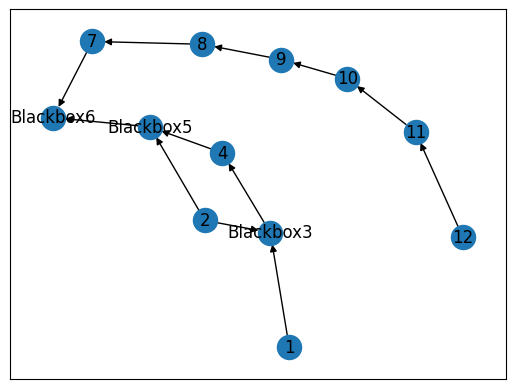

In [884]:
DG = generate_dg()
print(DG.get_all_params())
nx.draw_networkx(DG)
plt.show()

# Gradient Descent of local components

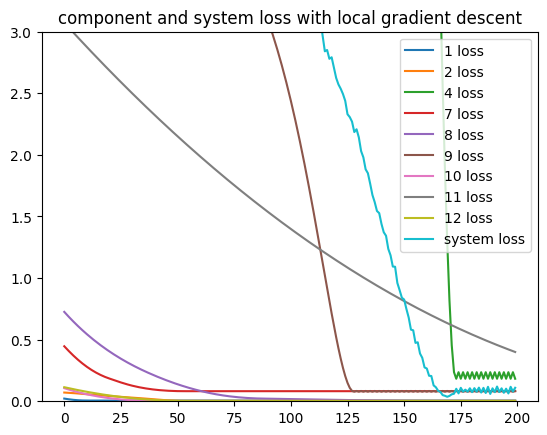

In [834]:
#grad descent
DG.random_initialize_param()

lower_bound_local_loss = show_system_loss_from_grad_descent(DG, itr=200, plot=True)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]

# Vanilla BO over all parameters

In [847]:

# vanilla BO
import botorch
botorch.settings.debug = True
DG.random_initialize_param()
DG.fit_locally_partial(10)
all_best_losses, _, _ = BO_graph(DG,printout=True,iteration=100)

BO iteration:  0
Current best objective:  -10000
BO iteration:  1
Current best objective:  tensor(-1.9619, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  2
Current best objective:  tensor(-1.9619, dtype=torch.float64)
BO iteration:  3
Current best objective:  tensor(-1.9619, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  4
Current best objective:  tensor(-1.5121, dtype=torch.float64)
BO iteration:  5
Current best objective:  tensor(-1.5121, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  6
Current best objective:  tensor(-1.5121, dtype=torch.float64)
BO iteration:  7
Current best objective:  tensor(-0.3157, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  8
Current best objective:  tensor(-0.2874, dtype=torch.float64)
BO iteration:  9
Current best objective:  tensor(-0.2787, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  10
Current best objective:  tensor(-0.2587, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  11
Current best objective:  tensor(-0.2587, dtype=torch.float64)
BO iteration:  12
Current best objective:  tensor(-0.2587, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  13
Current best objective:  tensor(-0.2587, dtype=torch.float64)
BO iteration:  14
Current best objective:  tensor(-0.2587, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  15
Current best objective:  tensor(-0.2587, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  16
Current best objective:  tensor(-0.2587, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  17
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  18
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  19
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  20
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  21
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  22
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  23
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  24
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  25
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  26
Current best objective:  tensor(-0.1854, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  27
Current best objective:  tensor(-0.1755, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  28
Current best objective:  tensor(-0.1755, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  29
Current best objective:  tensor(-0.1593, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  30
Current best objective:  tensor(-0.1593, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  31
Current best objective:  tensor(-0.1593, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  32
Current best objective:  tensor(-0.1593, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  33
Current best objective:  tensor(-0.1438, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  34
Current best objective:  tensor(-0.1438, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  35
Current best objective:  tensor(-0.1438, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  36
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  37
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  38
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  39
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  40
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  41
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  42
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  43
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  44
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  45
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  46
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  47
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  48
Current best objective:  tensor(-0.1320, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  49
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  50
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  51
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  52
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  53
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  54
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  55
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  56
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  57
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  58
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  59
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  60
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  61
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  62
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  63
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  64
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  65
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  66
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  67
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  68
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  69
Current best objective:  tensor(-0.1302, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  70
Current best objective:  tensor(-0.1159, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  71
Current best objective:  tensor(-0.1159, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  72
Current best objective:  tensor(-0.1159, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  73
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  74
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  75
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  76
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  77
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  78
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  79
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  80
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  81
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  82
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  83
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  84
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  85
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  86
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  87
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  88
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  89
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  90
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  91
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  92
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  93
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  94
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  95
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  96
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  97
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  98
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


BO iteration:  99
Current best objective:  tensor(-0.0915, dtype=torch.float64)


/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


# BO with gradient descent over local loss (ours)

In [845]:

DG.random_initialize_param()
# BO with local loss -> system loss
DG.fit_locally_partial(100)

bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 3])
all_best_losses_ours, best_param = BO_graph_local_loss(DG, bounds, "multi_search", iteration=10)

/tmp/ipykernel_133225/2211688774.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 3])
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


BO iteration:  0
Current best objective:  -10000
loss to look for:  tensor([1.0862e+01, 2.9710e-03, 3.1529e-02, 1.9400e-01, 1.5539e-02, 5.3613e-02,
        2.7897e-03, 1.6899e+00, 2.3094e-03], dtype=torch.float64)
number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisit

candidate: tensor([[0.0084, 0.0068, 0.3409, 0.1057, 0.0028, 0.2072, 0.0067, 0.4797, 0.0040]],
       dtype=torch.float64)
BO iteration:  1
Current best objective:  tensor(-2.9963, dtype=torch.float64)
loss to look for:  tensor([0.0084, 0.0068, 0.3409, 0.1057, 0.0028, 0.2072, 0.0067, 0.4797, 0.0040],
       dtype=torch.float64)
number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0169, 0.0039, 0.4253, 0.2356, 0.0033, 0.2460, 0.0051, 0.8784, 0.0043]],
       dtype=torch.float64)
BO iteration:  2
Current best objective:  tensor(-0.0641, dtype=torch.float64)
loss to look for:  tensor([0.0169, 0.0039, 0.4253, 0.2356, 0.0033, 0.2460, 0.0051, 0.8784, 0.0043],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0131, 0.0056, 0.3661, 0.1830, 0.0032, 0.2205, 0.0061, 0.7458, 0.0042]],
       dtype=torch.float64)
BO iteration:  3
Current best objective:  tensor(-0.0641, dtype=torch.float64)
loss to look for:  tensor([0.0131, 0.0056, 0.3661, 0.1830, 0.0032, 0.2205, 0.0061, 0.7458, 0.0042],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20
candidate: tensor([[0.0135, 0.0055, 0.3724, 0.1882, 0.0033, 0.2224, 0.0062, 0.7304, 0.0043]],
       dtype=torch.float64)
BO iteration:  4
Current best objective:  tensor(-0.0302, dtype=torch.float64)
loss to look for:  tensor([0.0135, 0.0055, 0.3724, 0.1882, 0.0033, 0.2224, 0.0062, 0.7304, 0.0043],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0138, 0.0056, 0.3693, 0.1922, 0.0033, 0.2229, 0.0064, 0.7441, 0.0043]],
       dtype=torch.float64)
BO iteration:  5
Current best objective:  tensor(-0.0302, dtype=torch.float64)
loss to look for:  tensor([0.0138, 0.0056, 0.3693, 0.1922, 0.0033, 0.2229, 0.0064, 0.7441, 0.0043],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0143, 0.0055, 0.3702, 0.1983, 0.0034, 0.2214, 0.0065, 0.7648, 0.0044]],
       dtype=torch.float64)
BO iteration:  6
Current best objective:  tensor(-0.0302, dtype=torch.float64)
loss to look for:  tensor([0.0143, 0.0055, 0.3702, 0.1983, 0.0034, 0.2214, 0.0065, 0.7648, 0.0044],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0143, 0.0056, 0.3754, 0.1952, 0.0034, 0.2224, 0.0066, 0.7781, 0.0045]],
       dtype=torch.float64)
BO iteration:  7
Current best objective:  tensor(-0.0302, dtype=torch.float64)
loss to look for:  tensor([0.0143, 0.0056, 0.3754, 0.1952, 0.0034, 0.2224, 0.0066, 0.7781, 0.0045],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0142, 0.0056, 0.3745, 0.1921, 0.0034, 0.2200, 0.0066, 0.7867, 0.0045]],
       dtype=torch.float64)
BO iteration:  8
Current best objective:  tensor(-0.0289, dtype=torch.float64)
loss to look for:  tensor([0.0142, 0.0056, 0.3745, 0.1921, 0.0034, 0.2200, 0.0066, 0.7867, 0.0045],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0143, 0.0056, 0.3771, 0.1929, 0.0035, 0.2178, 0.0067, 0.7931, 0.0045]],
       dtype=torch.float64)
BO iteration:  9
Current best objective:  tensor(-0.0289, dtype=torch.float64)
loss to look for:  tensor([0.0143, 0.0056, 0.3771, 0.1929, 0.0035, 0.2178, 0.0067, 0.7931, 0.0045],
       dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


number of combination of params with matching loss:  20


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:290: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


candidate: tensor([[0.0143, 0.0057, 0.3783, 0.1909, 0.0035, 0.2178, 0.0067, 0.7994, 0.0045]],
       dtype=torch.float64)


# Plot the losses

In [ ]:
s_loss_from_grad = system_loss_from_grad['system']
best_from_grad = min(s_loss_from_grad)
plt.plot(range(len(all_best_losses)), [-x for x in all_best_losses], label="BO over system parameters")
plt.plot(range(len(s_loss_from_grad)), [best_from_grad for x in range(len(s_loss_from_grad))], '--', c='black', label="Best system loss with local gradient descent", alpha=0.3)
plt.plot(range(len(all_best_losses_ours)), [-x for x in all_best_losses_ours], label="BO over local losses (with parameter lookup)")
plt.legend()
plt.title("System Loss over number of system queries")
plt.show()


# Perform partitioning based on M.I, and perform optimization of each sub-system

adding edge from Blackbox6 to Blackbox3
adding edge from 7 to Blackbox3
adding edge from 1 to Blackbox3
adding edge from 2 to Blackbox3
adding edge from 4 to Blackbox5
adding edge from 2 to Blackbox5
adding edge from 7 to Blackbox6
adding edge from Blackbox5 to Blackbox6


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:30: UserWarning: Parents of Blackbox3 previously defined as ['Blackbox6', 7], attempting to overwrite with [1, 2]
  warnings.warn(f'Parents of {v_of_edge} previously defined as {self.nodes[v_of_edge]["parents"]}, attempting to overwrite with {u_of_edge}')
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:30: UserWarning: Parents of 4 previously defined as [2], attempting to overwrite with ['Blackbox3']
  warnings.warn(f'Parents of {v_of_edge} previously defined as {self.nodes[v_of_edge]["parents"]}, attempting to overwrite with {u_of_edge}')


MI:  [0.46120676 0.05444554 0.1214082  0.05315157 0.         0.01440395
 0.0737174  0.         0.00267283]
cluster in decomposition:  {1, 'Blackbox3'}
cluster in decomposition:  {2, 'Blackbox5'}
cluster in decomposition:  {'Blackbox6', 7}
decomposition score:  0.005554463891197906
cluster in decomposition:  {1, 'Blackbox3'}
cluster in decomposition:  {2, 'Blackbox5'}
cluster in decomposition:  {'Blackbox6', 8, 7}
decomposition score:  0.015554463891197905
cluster in decomposition:  {1, 'Blackbox3'}
cluster in decomposition:  {2, 'Blackbox5'}
cluster in decomposition:  {'Blackbox6', 8, 9, 7}
decomposition score:  0.025554463891197907
cluster in decomposition:  {1, 'Blackbox3'}
cluster in decomposition:  {2, 'Blackbox5'}
cluster in decomposition:  {7, 'Blackbox6', 8, 10, 9}
decomposition score:  0.03555446389119791
cluster in decomposition:  {1, 'Blackbox3'}
cluster in decomposition:  {2, 'Blackbox5'}
cluster in decomposition:  {7, 'Blackbox6', 8, 10, 11, 9}
decomposition score:  0.04555

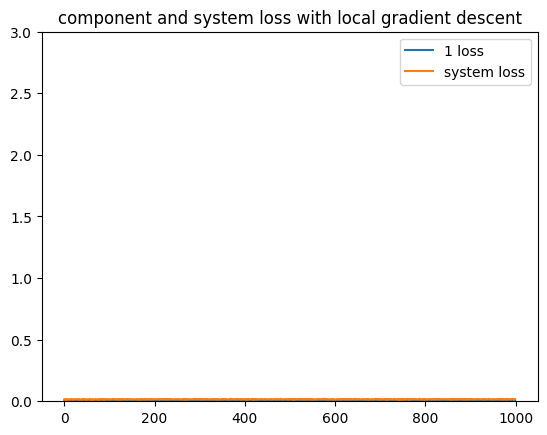

system loss at after descent:  tensor(0.0168, dtype=torch.float64)
BO iteration:  0
Current best objective:  -10000
loss to look for:  tensor([1.6533], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


5
20
5
number to sample:  5
[(1,), (3,), (2,), (0,), (4,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  1
Current best objective:  tensor(-2.8717, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(4,), (1,), (3,), (2,), (0,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0022]], dtype=torch.float64)
BO iteration:  2
Current best objective:  tensor(-0.0156, dtype=torch.float64)
loss to look for:  tensor([0.0022], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(3,), (1,), (2,), (0,), (4,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0022]], dtype=torch.float64)
BO iteration:  3
Current best objective:  tensor(-0.0117, dtype=torch.float64)
loss to look for:  tensor([0.0022], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(0,), (1,), (2,), (4,), (3,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  4
Current best objective:  tensor(-0.0117, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(2,), (1,), (4,), (0,), (3,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  5
Current best objective:  tensor(-0.0062, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(3,), (2,), (0,), (1,), (4,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  6
Current best objective:  tensor(-0.0062, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(0,), (4,), (2,), (3,), (1,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  7
Current best objective:  tensor(-0.0062, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(1,), (4,), (3,), (0,), (2,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  8
Current best objective:  tensor(-0.0062, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(0,), (3,), (1,), (4,), (2,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)
BO iteration:  9
Current best objective:  tensor(-0.0062, dtype=torch.float64)
loss to look for:  tensor([0.0065], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use

5
20
5
number to sample:  5
[(4,), (0,), (3,), (1,), (2,)]
number of combination of params with matching loss:  5
candidate: tensor([[0.0065]], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [883]:
# assign M.I to each component
DG = generate_dg()
DG = assign_mi(DG)

# get decomposition via some partitioning method
all_black_box = ["Blackbox3", "Blackbox5", "Blackbox6"]
all_decomp = find_all_decomposition_full(all_black_box, DG)
all_valid_decomp = get_all_valid_decomposition(all_decomp)
best_decomposition, score = get_best_decomposition(all_valid_decomp, DG, l=1, measure="mi")

# for each decomposition, optimize it
for sub_system_set in best_decomposition:
    print("subsystem: ", sub_system_set)
    graph_temp = copy.deepcopy(DG)
    sub_system = generate_sub_system(sub_system_set, graph_temp, ground_truth_param)
    X,y = get_end_to_end_data(sub_system,ground_truth_param)
    
    sub_system.system_x = X
    sub_system.system_y = y
    
    # vanilla BO
    # all_best_losses, _, _ = BO_graph(graph_temp,printout=False,iteration=10)
    
    # ours
    sub_system.random_initialize_param()
    sub_system.fit_locally_partial(100)

    lower_bound_local_loss = show_system_loss_from_grad_descent(sub_system, itr=1000, plot=True)
    lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
    print("system loss at after descent: ", sub_system.get_system_loss())
    sub_system.random_initialize_param()
    bounds = torch.tensor([np.array(lower_bound_local_loss), np.array(lower_bound_local_loss) * 3])
    all_best_losses_ours, best_param = BO_graph_local_loss(sub_system, bounds, "multi_search", iteration=10)
    break


# For debugging purposes: provide a fixed partitioning

In [874]:

DG.random_initialize_param()
sub_system = {1, 2, 'Blackbox3'}
sub_system = generate_sub_system(sub_system, DG, ground_truth_param)
print("subsystem local loss: ", sub_system.get_local_losses())
print("subsystem system loss: ", sub_system.get_system_loss())

# vanilla
# all_best_losses, _, _ = BO_graph(sub_system,printout=False,iteration=50)

# ours
sub_system.random_initialize_param()
sub_system.fit_locally_partial(100)

lower_bound_local_loss = show_system_loss_from_grad_descent(sub_system, itr=500, plot=False)
lower_bound_local_loss = [x.detach().numpy().tolist() for x in lower_bound_local_loss]
bounds = torch.tensor([np.array(lower_bound_local_loss)*1.1, np.array(lower_bound_local_loss) * 3])
all_best_losses_ours, best_param = BO_graph_local_loss(sub_system, bounds, "multi_search", iteration=10)

subsystem local loss:  tensor([[0.0195, 0.2991]], dtype=torch.float64)
subsystem system loss:  tensor(0.0193, dtype=torch.float64)
BO iteration:  0
Current best objective:  -10000
loss to look for:  tensor([0.0027, 0.0026], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(1, 1), (2, 1), (0, 1), (1, 2), (2, 0), (0, 0), (2, 2), (1, 0), (0, 2)]
number of combination of params with matching loss:  9


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


candidate: tensor([[0.0081, 0.0078]], dtype=torch.float64)
BO iteration:  1
Current best objective:  tensor(-0.0088, dtype=torch.float64)
loss to look for:  tensor([0.0081, 0.0078], dtype=torch.float64)
9
20
9
number to sample:  9
[(1, 0), (1, 1), (2, 0), (0, 2), (2, 2), (1, 2), (2, 1), (0, 1), (0, 0)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0078]], dtype=torch.float64)
BO iteration:  2
Current best objective:  tensor(-0.0071, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0078], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(0, 0), (1, 0), (0, 1), (2, 0), (0, 2), (2, 1), (2, 2), (1, 2), (1, 1)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0081, 0.0078]], dtype=torch.float64)
BO iteration:  3
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0081, 0.0078], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(2, 1), (2, 2), (0, 1), (0, 2), (2, 0), (1, 1), (0, 0), (1, 0), (1, 2)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0028]], dtype=torch.float64)
BO iteration:  4
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0028], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(2, 1), (1, 1), (2, 0), (0, 1), (1, 0), (1, 2), (0, 2), (0, 0), (2, 2)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0078]], dtype=torch.float64)
BO iteration:  5
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0078], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(2, 1), (2, 0), (1, 1), (0, 0), (0, 2), (1, 0), (0, 1), (2, 2), (1, 2)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0028]], dtype=torch.float64)
BO iteration:  6
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0028], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(1, 2), (1, 0), (0, 2), (0, 1), (2, 1), (2, 0), (2, 2), (0, 0), (1, 1)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0028]], dtype=torch.float64)
BO iteration:  7
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0028], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(2, 2), (2, 0), (2, 1), (1, 0), (0, 2), (1, 1), (1, 2), (0, 0), (0, 1)]
number of combination of params with matching loss:  9


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


candidate: tensor([[0.0030, 0.0078]], dtype=torch.float64)
BO iteration:  8
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0078], dtype=torch.float64)
9
20
9
number to sample:  9
[(2, 2), (2, 1), (0, 0), (1, 2), (0, 1), (1, 1), (1, 0), (0, 2), (2, 0)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0028]], dtype=torch.float64)
BO iteration:  9
Current best objective:  tensor(-0.0067, dtype=torch.float64)
loss to look for:  tensor([0.0030, 0.0028], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(self.get_local_losses(), torch.tensor(losses))


9
20
9
number to sample:  9
[(2, 0), (2, 1), (0, 2), (1, 1), (1, 2), (2, 2), (0, 0), (0, 1), (1, 0)]
number of combination of params with matching loss:  9
candidate: tensor([[0.0030, 0.0028]], dtype=torch.float64)


/home/zhiliang/dev/AutoAI/GraphDecomposition/DirectedFunctionalGraph.py:296: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  norm_difference = torch.subtract(torch.tensor(self.get_local_losses()), torch.tensor(losses))
/home/zhiliang/.local/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)
